In [1]:
import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as de
import h5py
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
train_loss_256 = np.load("all_snapshots_training/training_costs_pi.npy")
test_loss_256 = np.load("all_snapshots_training/testing_costs_pi.npy")
#train_loss_128 = np.load("simulation_10/filtered_N128/training_costs_pi.npy")
#test_loss_128 = np.load("simulation_10/filtered_N128/testing_costs_pi.npy")

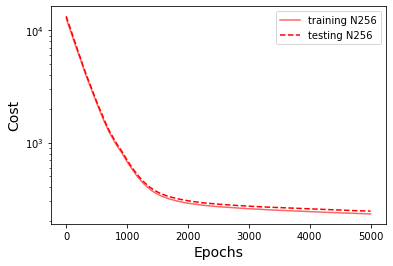

In [6]:
plt.plot(train_loss_256/140,label="training N256",color='r',alpha=0.6)
plt.plot(test_loss_256/20,label="testing N256",color='r',ls='--')
#plt.plot(train_loss_128,label="training N128",color='b',alpha=0.6)
#plt.plot(test_loss_128,label="testing N128",color='b',ls='--')
plt.ylabel("Cost",fontsize=14)
plt.xlabel("Epochs",fontsize=14)
plt.legend()
plt.yscale('log')
plt.savefig("cost_plot.png",dpi=200)
plt.show()

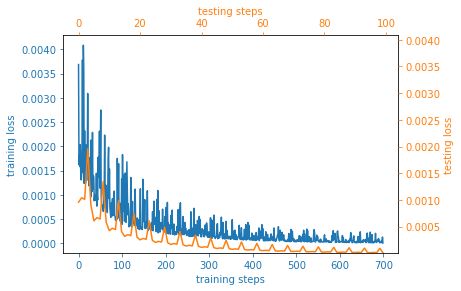

In [5]:
fig=plt.figure()
ax=fig.add_subplot(111, label="1")
ax2=fig.add_subplot(111, label="2", frame_on=False)
#ax3=fig.add_subplot(111, label="3", frame_on=False)

ax.plot(train_loss_full, color="C0")
ax.set_xlabel("training steps", color="C0")
ax.set_ylabel("training loss", color="C0")
ax.tick_params(axis='x', colors="C0")
ax.tick_params(axis='y', colors="C0")

ax2.plot(test_loss_full, color="C1")
ax2.xaxis.tick_top()
ax2.yaxis.tick_right()
ax2.set_xlabel('testing steps', color="C1") 
ax2.set_ylabel('testing loss', color="C1")       
ax2.xaxis.set_label_position('top') 
ax2.yaxis.set_label_position('right') 
ax2.tick_params(axis='x', colors="C1")
ax2.tick_params(axis='y', colors="C1")
ax2.set_ylim(np.min(train_loss_full),np.max(train_loss_full))
#plt.savefig("loss.png")
plt.show()

In [2]:
from dedalus.core.field import Operand
from dedalus.core.operators import Operator, FutureField

In [11]:
class Convolve(Operator, FutureField):
    """Basic convolution operator."""

    name = 'Conv'

    def meta_constant(self, axis):
        return (self.args[0].meta[axis]['constant'] and
                self.args[1].meta[axis]['constant'])

    def check_conditions(self):
        # Coefficient layout
        arg0, arg1 = self.args
        return ((arg0.layout == self._coeff_layout) and
                (arg1.layout == self._coeff_layout))

    def operate(self, out):
        arg0, arg1 = self.args
        arg0.require_coeff_space()
        arg1.require_coeff_space()
        # Multiply coefficients
        out.layout = self._coeff_layout
        np.multiply(arg0.data, arg1.data, out=out.data)

In [12]:
def get_filter(N,domain):
    kmax = (N - 1) // 2
    eta = domain.new_field(name='eta')
    kx = domain.elements(0)
    ky = domain.elements(1)
    eta['c'] = 1
    eta['c'] *= np.abs(kx) <= kmax
    eta['c'] *= np.abs(ky) <= kmax
    Filter = lambda field, eta=eta: Convolve(eta, field)
    
    return Filter

In [3]:
# Domain
L = 1
Npix = 2048
Bx = By = (-np.pi*L, np.pi*L)
Nx = Ny = Npix
mesh = None

# Physical parameters
Re = 32000  # V * L / ν
V = L  # tc = L / V = 1
k = 1 / L
ν = V * L / Re

k_scaling = 3/5

# Kraichnan turbulence forcing
Fx = 0
Fy = 0

# Coarse grained resolution
N = 256

In [32]:
with h5py.File("snapshots_s90.h5", mode='r') as file:
    w = file['tasks']['w']
    t = file['scales']['sim_time']
    w_data = np.array(w)[0]

In [20]:
x_basis = de.Fourier('x', Nx, interval=(0,1), dealias=1)
y_basis = de.Fourier('y', Ny, interval=(0,1), dealias=1)
domain = de.Domain([x_basis, y_basis], grid_dtype=np.float64)

In [33]:
Filter = get_filter(N,domain)
w = domain.new_field(name='w_filt')
w['g'] = w_data
w_filt = Filter(w).evaluate()

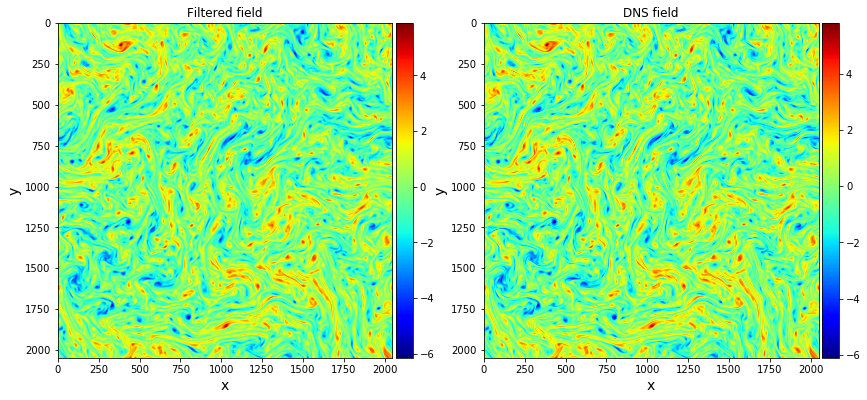

In [34]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(14, 18)

p1 = ax1.imshow(w_filt['g'],cmap='jet')
ax1.set_title("Filtered field")
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(p1, cax=cax)

ax1.set_xlabel("x",fontsize=14)
ax1.set_ylabel("y",fontsize=14)

p2 = ax2.imshow(w_data[:,:],cmap='jet')
ax2.set_title("DNS field")
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(p2, cax=cax)

ax2.set_xlabel("x",fontsize=14)
ax2.set_ylabel("y",fontsize=14)

plt.show()

In [8]:
# Generate random vorticity field using red noise
x = domain.grid(0)
y = domain.grid(1)
kx = domain.elements(0)
ky = domain.elements(1)
k = np.array(np.meshgrid(ky,kx))
k = np.sqrt(k[0]**2 + k[1]**2)
w = domain.new_field(name='w')
w['g'] = np.random.normal(0,1,(x.shape[0],y.shape[1]))
# Small term in division by k is included to avoid blow up at k = 0
w['c'] = w['c']/(k+0.0000001)**(k_scaling)
# normalize vorticity field
w['g'] = (w['g']-np.mean(w['g']))/np.std(w['g'])

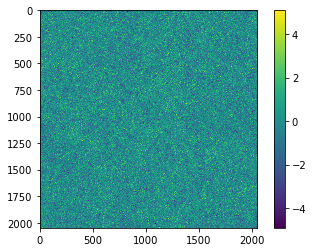

In [10]:
plt.imshow(w['g'])
plt.colorbar()
plt.show()